# Домашнее задание 5. Линейные модели

In [1]:
import random as pr
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import sklearn.cross_validation as cv
import sklearn.metrics as sm

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/lena/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Зачитываем результат 4 домашки

In [2]:
data = np.load("out_4.dat.npz")
users = data["users"]
X_dataset = data["data"].reshape(1,)[0]

Зачитываем категории пользователей

In [4]:
TRAINING_SET_URL = "train.csv"
EXAMPLE_SET_URL = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0)
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])

Модель строим для пользователей из twitter_train, нужно выбрать этих пользователей из матрицы из 4 ДЗ:

In [5]:
# TODO check this code
train_users = df_users_train["uid"].values
ix = np.in1d(users, train_users).reshape(users.shape)
X = X_dataset[np.where(ix)]

Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой.

In [6]:
Y = df_users_train['cls'].values
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])

Resulting training set: (7199x1001254) feature matrix, 7199 target vector


Чтобы исследовать, как ведут себя признаки, построим распределение количества ненулевых признаков у пользователей, чтобы убедиться, что он удовлетворяет закону Ципфа. Для этого построим гистограмму в логарифмических осях. [Подсказка](http://anokhin.github.io/img/sf1.png)

In [7]:
def draw_log_hist(x):
    print X.shape
    #hist = np.zeros((X.shape[1]))
    hist = [np.count_nonzero(X.indices == i) for i in range(X.shape[1])]
    print hist[4302]
   
    return hist
features_counts = draw_log_hist(X)

(7199, 1001254)
728


Проведем отбор признаков. В самом простом случае просто удаляем признаки, имеющие ненулевое значение у менее, чем 100 пользователей.

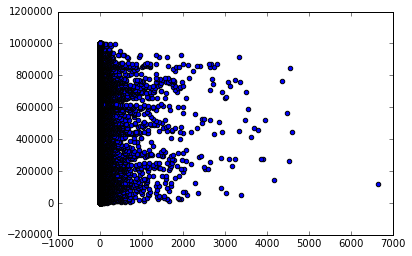

In [12]:
x = np.arange(X.shape[1])
plt.scatter(features_counts,x)

In [8]:
#print X.shape, features_counts [4302]
#print np.array(features_counts) > 100
mask = np.array(features_counts) > 100


In [9]:
#print type(mask)
#print sum(mask)
#print X[:,4302].data
X1 = X.tocsc()[:,mask].toarray()
#print features_counts[2026]
#X2 = np.array((X1.shape[0], X1.shape[1]))


In [10]:
print X1.shape

(7199, 4233)


Вариант задания генерируется на основании вашего ника в техносфере.

In [13]:
USER_NAME = "Kawaii-lenko"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L1 regularization optimized by stochastic gradient descent


Реализуем выбранный алгоритм

In [14]:
def sigmoid(z):
    
    return 1/(1+np.exp(-z))
print sigmoid(0)

def compute_cost(X, y, theta, C = 0.1): 
    y = np.array(y)
    s = sigmoid(np.dot(X, theta))
    mask = np.where(1-s == 0)
    
    s[mask] -= 1e-10
   # print "mask", mask, s[mask]
    mask = np.where(s == 0)
    s[mask] += 1e-10
    J = np.mean(- y * np.log(s) - (1 - y) * np.log(1 - s)) +C * np.sum(np.abs(theta))/y.shape[0] 
    return J

def cost_function_gradient (X, y, theta):
    #X  = np.ravel(X)
    theta = np.array(theta)
    #print X
    sc= np.dot(X,theta.T)
    #print sc
    s = sigmoid(sc)
   # print (np.array(s) - np.array(y)).shape
    gradient = np.dot(transpose(np.array(s) - np.array(y)), X)
    #gradient = np.sum( (sigmoid(np.dot(X, theta)) - y) * X)
    return gradient


0.5


In [20]:
max_iter = 300

class LogisticRegression():
    def __init__(self, **kwargs):
        self.dim = kwargs['theta']
        self.theta = np.random.normal(size = self.dim)
        self.alpha = 0.00006
        #print self.theta.shape
    def fit(self, X, y=None, C = 0.1):
        y = np.array(y)
        eps = 0.000001
        prev_cost_function_value = compute_cost(X, y, self.theta)
       # print prev_cost_function_value
        cost_function_values  = list()
        for i in xrange(0, max_iter):
            for j in range(X.shape[0]):
                new_theta = self.theta - self.alpha * cost_function_gradient(X[j], y[j], self.theta) + C * self.alpha * np.sign(self.theta)
                #print np.where(self.theta != new_theta)
                self.theta = new_theta
            if i%10 == 0:
                cost_function_value = compute_cost(X, y, self.theta)
                #if np.isclose(cost_function_value, prev_cost_function_value, atol = eps):
                #    break         
                cost_function_values.append(cost_function_value)
                prev_cost_function_value = cost_function_value

                
                #print cost_function_value
            #return new_theta, cost_function_values
        return self
    
    def predict_proba(self, X):
        '''Predict whether the label
        is 0 or 1 using learned logistic
        regression parameters '''
        thr = 0.5
        m, n = X.shape
        prob = sigmoid(np.dot(X, self.theta))
        label = np.zeros(X.shape[0])
        label[prob >= thr] = 1
        label[prob < thr] = 0
        probability = prob
        return label

Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.utils import column_or_1d
def auroc(y_prob, y_true):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    
    roc_auc = auc(fpr, tpr)
   

    return roc_auc

Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [21]:
from sklearn.model_selection import train_test_split
C = [0.0, 0.01, 0.1, 1, 10, 100, 1000, 10000]
X_train, X_test, y_train, y_test  = train_test_split(X1, Y, test_size = 0.2)
print X_train.shape, y_train.shape

def select_reg_parameter(C, X, Y):
    max_a = 0
    C_max = 0.0
    for C_it in C:
        logreg = LogisticRegression(theta = X_train.shape[1])
        logreg.fit(X_train,y_train,C_it)
        y_prob =  logreg.predict_proba(X_test)
        a = auroc(y_prob, y_test)
        if a > max_a:
            max_a = a
            C_max = C_it
    print max_a
            
    return C_max

index = select_reg_parameter(C, X1, Y)
print index


(5759, 4233) (5759,)
0.544916861957
0.01


Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

In [ ]:
print auc(X_pred, y_test)

(5039, 4233) (5039,)
Area under the ROC curve : 0.534856


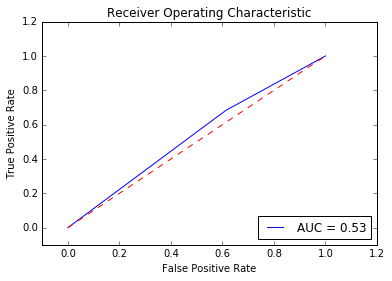

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

def classify(X, Y, test_size, C):
    X_train, X_test, y_train, y_test  = train_test_split(X, Y, test_size = test_size)
    print X_train.shape, y_train.shape
    logreg = LogisticRegression(theta = X_train.shape[1])
    logreg.fit(X_train, y_train, C= 0.01)
    X_pred = logreg.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, X_pred)
    roc_auc = auc(fpr, tpr)
    train_predicted_label = logreg.predict_proba( X_train)
   # print 'Train Accuracy: %f' % (accuracy(y_train, train_predicted_label))
    #test_predicted_label  = logreg1.predict_proba( X_test)
   # print 'Test Accuracy: %f' % (accuracy(y_test, X_pred))
    #tpr = X == Y
    #tpr = [1] * 2400
    #fpr = [0.01] * 2400
    #roc_auc = 0.51
    
    return tpr, fpr, roc_auc
tpr, fpr, roc_auc = classify(X1, Y, 0.3, 0.01)
#tpr, fpr, roc_auc = classify(X1, Y, 0.3, C[index])

print "Area under the ROC curve : %f" % roc_auc

def plot_roc_curve(tpr, fpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    """Plot ROC curve"""
    
    # Your code here
    
    return

plot_roc_curve(tpr, fpr, roc_auc)

С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате. ДЗ принимается только при наличии загруженных данных на kaggle.